In [20]:
from __future__ import print_function
import os
import time
import copy
import json
import yaml

import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision
from typing import *

In [21]:
from utils.util import *
from config.data_config import DATASET
from utils.dataset import DefaultDatasetSetupSSL
from self_supervised.losses.contrastive_loss import (
    ContrastiveLossEuclidean,
    ContrastiveLossEmbedding,
    SimCLR_Loss,
    NegativeCosineSimilarity,
)
from self_supervised.losses.sym_neg_cos_sim_loss import SymNegCosineSimilarityLoss

from models.modules.head import BYOLProjectionHead, BYOLPredictionHead
from utils.scheduler import cosine_schedule
from torch.utils.data import DataLoader, random_split
from einops.layers.torch import Rearrange
from config.cvt_config import CvT_CONFIG
from models.transformer_zoo import TransformerModels
import math
from transformers import get_cosine_schedule_with_warmup
from utils.inference import InferenceSSL
import logging

In [22]:
import torch
import torchvision
from torch import nn

from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimSiamTransform

In [23]:
batch_size = 2
dataset_name = "Model_II"
dataset_dir = "data"
use_cuda = True
num_workers = 20

log_dir_base = "logger"
classes = DATASET[f"{dataset_name}"]["classes"]
num_classes = len(classes)

In [24]:
# learning_rate = train_config["optimizer_config"]["lr"]
train_config = CvT_CONFIG
num_channels = train_config["channels"]
network_type = train_config["network_type"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]
network_config=  train_config["network_config"]

make_directories([dataset_dir])
seed_everything(seed=42)

In [25]:
# logging
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = f"{log_dir_base}/{current_time}"
init_logging_handler(log_dir_base, current_time)

In [26]:
# paths
model_path_pretrained = os.path.join(
    f"{log_dir}/checkpoint",
   f"{network_type}_pretrained_{dataset_name}_{current_time}.pt",
)

finetuned_model_path = os.path.join(
    f"{log_dir}/checkpoint",
    f"{network_type}_finetune_{dataset_name}_{current_time}.pt",
)

In [27]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


class SimSiamTransform:
    """Implements the augmentations for SimSiam.
    """

    def __init__(self):
        pass
    
    def get_transforms(self, 
                       global_crop_size: int = 224,
                       global_crop_scale: Tuple[float, float] = (0.4, 1.0),
                       local_crop_size: int = 96,
                       local_crop_scale: Tuple[float, float] = (0.05, 0.4),):

        # first global crop
        transform = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.RandomResizedCrop(height=global_crop_size, width=global_crop_size),
            A.Rotate(p=0.5), 
            ToTensorV2(),
        ])

        return [transform, transform]
    

Model_II dataset already exists


DEBUG:root:train data: 89104


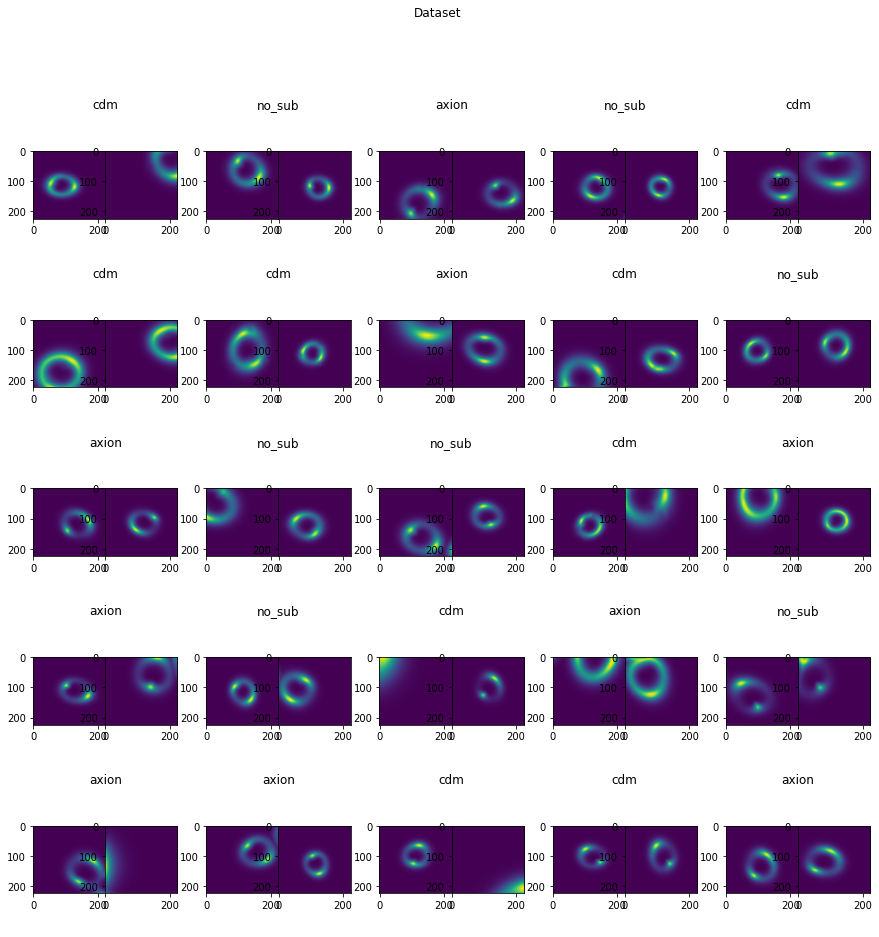

In [28]:
from utils.dataset import visualize_samples_ssl, DeepLenseDatasetSSL
# trainset
dino_transform = SimSiamTransform()
train_transforms = dino_transform.get_transforms()
train_dataset = DeepLenseDatasetSSL(destination_dir = dataset_dir, transforms = train_transforms, mode="train", dataset_name=dataset_name, download=True, channels=1)
logging.debug(f"train data: {len(train_dataset)}")
visualize_samples_ssl(train_dataset, labels_map=classes, num_rows_inner=1, num_cols_inner=2)

In [29]:
# split in train and valid set
split_ratio = 0.25  # 0.25
valid_len = int(split_ratio * len(train_dataset))
train_len = len(train_dataset) - valid_len

train_dataset, val_set = random_split(train_dataset, [train_len, valid_len])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

# Load test dataset
# testset = default_dataset_setup.get_dataset(mode="val")
# test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

# size check
sample = next(iter(train_loader))
logging.debug("num of classes: ", num_classes)
logging.debug(sample[0].shape)

--- Logging error ---
Traceback (most recent call last):
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 1081, in emit
    msg = self.format(record)
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 925, in format
    return fmt.format(record)
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 664, in format
    record.message = record.getMessage()
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/site-packages/ipykernel_launcher

In [30]:
class SimSiamTransformer(nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(input_dim, 512, 128)
        self.prediction_head = SimSiamPredictionHead(128, 64, 128)

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p



In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
in_features = 128

In [33]:
# Transformer model
backbone = TransformerModels(
    transformer_type=train_config["network_type"],
    num_channels=train_config["channels"],
    num_classes=in_features,
    img_size=image_size,
    **network_config, # **train_config["network_config"]
)


model = SimSiamTransformer(backbone, input_dim=in_features)
model.to(device)
summary(model, input_size=(2, 1, 224, 224), device=device)

Layer (type:depth-idx)                                                      Output Shape              Param #
SimSiamTransformer                                                          --                        --
├─CvT: 1-1                                                                  [2, 128]                  --
│    └─Sequential: 2-1                                                      [2, 128]                  --
│    │    └─Sequential: 3-1                                                 [2, 64, 56, 56]           206,080
│    │    └─Sequential: 3-2                                                 [2, 128, 28, 28]          1,008,000
│    │    └─Sequential: 3-3                                                 [2, 384, 14, 14]          8,369,280
│    │    └─AdaptiveAvgPool2d: 3-4                                          [2, 384, 1, 1]            --
│    │    └─Rearrange: 3-5                                                  [2, 384]                  --
│    │    └─Linear: 3-6        

In [34]:
epochs_pretrain = 1
finetune_epochs = 1

In [35]:
#optimizer
lr = 1e-3
optimizer_pretrain = optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-4)
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs_pretrain)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_pretrain,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [36]:
criterion = NegativeCosineSimilarity()

In [37]:
# dump config in logger
with open(f"{log_dir}/config.json", "w") as fp:
    json.dump(train_config, fp)

In [38]:
logging.debug("Starting Training")
for epoch in range(epochs_pretrain):
    total_loss = 0    
    best_loss = float("inf")

    for batch_idx, batch in enumerate(train_loader):
        x0 = batch[0] 
        x1 = batch[1] 
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0, p0 = model(x0)
        z1, p1 = model(x1)
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        total_loss += loss.detach()
        loss.backward()
        optimizer_pretrain.step()
        optimizer_pretrain.zero_grad()
        cosine_scheduler.step()
        

        if batch_idx % 10 == 0:
            logging.debug(f"Epoch [{epoch}/{epochs_pretrain}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}")

    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(model.state_dict(), model_path_pretrained)

    avg_loss = total_loss / len(train_loader)
    logging.debug(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")


DEBUG:root:Starting Training
DEBUG:root:Epoch [0/1], Batch [0/33414], Loss: -0.03896643966436386
DEBUG:root:Epoch [0/1], Batch [10/33414], Loss: 0.015265010297298431
DEBUG:root:Epoch [0/1], Batch [20/33414], Loss: 0.01884414441883564
DEBUG:root:Epoch [0/1], Batch [30/33414], Loss: -0.023109767585992813


KeyboardInterrupt: 

In [ ]:
class FinetuneClassifierTransformer(nn.Module):
    def __init__(self, backbone, head):
        super(FinetuneClassifierTransformer, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        z = self.backbone[0](x).flatten(start_dim=1)
        z = self.backbone[1](z)
        z = self.head(z)
        return z

In [ ]:
# load model
backbone = nn.Sequential(model.backbone, model.projection_head)
classification_head = nn.Sequential(
    nn.Linear(in_features, 512), # num_ftrs_dict["resnet34"]
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, num_classes),)

model =  FinetuneClassifierTransformer(backbone, classification_head) # num_ftrs_dict["resnet34"]
# model.load_state_dict(torch.load(model_path_pretrained))
summary(model, input_size=(2, 1, 224, 224), device="cuda")

In [ ]:
import math
learning_rate = 3e-4 # 3e-4
weight_decay =  0.01

finetune_optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)



#optimizer
optimizer_finetune = optim.AdamW(model.parameters(), lr=learning_rate) #  weight_decay = 1e-4
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * finetune_epochs)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_finetune,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [ ]:
finetune_criterion = nn.CrossEntropyLoss()

In [ ]:
def finetune(
    epochs: int,
    model: nn.Module,
    device: Union[int, str],
    train_loader: Any,
    criterion: nn.Module,
    optimizer: nn.Module,
    saved_model_path: str,
    valid_loader: Any,
):
    best_loss = float("inf")
    best_accuracy = float("-inf")
    all_val_loss = []
    all_val_accuracy = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()

        for batch_idx, batch in enumerate(train_loader): # for batch_idx, batch in enumerate(train_loader):
            img1 = batch[0].to(device)
            label = batch[-1].to(device)
            optimizer.zero_grad()
            output = model(img1)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            # cosine_scheduler.step()
            epoch_loss += loss
            
            
            if batch_idx % 100 == 0:
                logging.debug(
                    f"Epoch [{epoch}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}"
                )

        epoch_loss = epoch_loss / len(train_loader)

        with torch.no_grad():
            logging.debug("====== Eval started ======")
            model.eval()
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for batch_idx, batch in enumerate(valid_loader): # for batch_idx, batch in enumerate(train_loader):
                data = batch[0].to(device)
                label = batch[-1].to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss
                
                
                 

            epoch_val_accuracy = epoch_val_accuracy / len(valid_loader)
            
            if epoch_val_accuracy > best_accuracy:
                best_accuracy = epoch_val_accuracy
                torch.save(model.state_dict(), saved_model_path)
                logging.debug("====== Model saved ======")
            
            epoch_val_loss = epoch_val_loss / len(valid_loader)
            all_val_loss.append(epoch_val_loss)

        all_val_accuracy.append(epoch_val_accuracy.item() * 100)

        logging.debug(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} \n"
        )

In [ ]:
# Training loop
finetune(
    finetune_epochs,
    model,
    device,
    train_loader,
    finetune_criterion,
    finetune_optimizer,
    finetuned_model_path,
    valid_loader=val_loader,
)

In [ ]:
test_dataset_dir = dataset_dir
test_dataset = DeepLenseDatasetSSL(destination_dir = test_dataset_dir, transforms = train_transforms, mode="test", dataset_name=dataset_name, download=True, channels=1)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

In [ ]:
channels = 1
infer_obj = InferenceSSL(
    model,
    test_loader,
    device,
    num_classes,
    test_dataset,
    dataset_name,
    labels_map=classes, # classes
    image_size=image_size,
    channels=channels,
    destination_dir="data",
    log_dir=log_dir,  # log_dir
)

infer_obj.infer_plot_roc()
infer_obj.generate_plot_confusion_matrix()